Raw EEG Signal
    ↓
[1. Bandpass Filter] (0.5-50 Hz)
    ↓
[2. Notch Filter] (60 Hz, CHB-MIT only)
    ↓
[3. Normalization] (z-score)
    ↓
[4. Segmentation] (4s windows, 50% overlap)
    ↓
[5. Artifact Removal] (threshold-based)
    ↓
[6. Data Augmentation] (balance classes)
    ↓
[7. Train/Val/Test Split] (70/15/15)
    ↓
Ready for Feature Extraction!

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import signal
import mne
from tqdm import tqdm
import joblib
import warnings

# Import custom modules
import sys
sys.path.append('../src')
from data_loaders import BonnDataLoader, CHBMITDataLoader
from preprocessing import EEGPreprocessor, preprocess_pipeline

warnings.filterwarnings('ignore')

In [5]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

np.random.seed(42)

In [6]:
DATA_DIR = Path('../data')
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'
FIGURES_DIR = Path('../results/figures')

# Dataset paths
BONN_PATH = RAW_DIR / 'bonn'
CHB_MIT_PATH = RAW_DIR / 'chb-mit'

# Preprocessing parameters
PREPROCESSING_CONFIG = {
    'bonn': {
        'sampling_rate': 173.61,
        'bandpass_low': 0.5,
        'bandpass_high': 50.0,
        'apply_notch': False,  # Bonn data is clean
        'window_size': 4.0,    # seconds
        'overlap': 0.5,        # 50% overlap
        'normalization': 'zscore'
    },
    'chb_mit': {
        'sampling_rate': 256.0,
        'bandpass_low': 0.5,
        'bandpass_high': 50.0,
        'apply_notch': True,   # Remove 60 Hz power line
        'notch_freq': 60.0,
        'window_size': 4.0,
        'overlap': 0.5,
        'normalization': 'zscore'
    }
}

In [7]:
def plot_preprocessing_comparison(original, processed, sampling_rate, title="Signal Preprocessing", duration=5.0):
    """Compare original and preprocessed signals"""
    samples = int(duration * sampling_rate)
    time = np.arange(samples) / sampling_rate
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    
    # Original signal
    axes[0].plot(time, original[:samples], linewidth=0.5, alpha=0.8)
    axes[0].set_ylabel('Amplitude (μV)', fontsize=11)
    axes[0].set_title('Original Signal', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Preprocessed signal
    axes[1].plot(time, processed[:samples], linewidth=0.5, 
                color='green', alpha=0.8)
    axes[1].set_xlabel('Time (seconds)', fontsize=11)
    axes[1].set_ylabel('Amplitude (normalized)', fontsize=11)
    axes[1].set_title('Preprocessed Signal (Filtered + Normalized)', 
                     fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    return fig



In [8]:
def plot_frequency_comparison(original, processed, sampling_rate, title="Frequency Spectrum Comparison"):
    """Compare frequency spectra before and after preprocessing"""
    from scipy.signal import welch
    
    # Compute power spectral density
    freqs_orig, psd_orig = welch(original, fs=sampling_rate, nperseg=256)
    freqs_proc, psd_proc = welch(processed, fs=sampling_rate, nperseg=256)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Original spectrum
    mask = freqs_orig <= 50
    axes[0].semilogy(freqs_orig[mask], psd_orig[mask])
    axes[0].set_xlabel('Frequency (Hz)', fontsize=11)
    axes[0].set_ylabel('Power Spectral Density', fontsize=11)
    axes[0].set_title('Original Signal Spectrum', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Preprocessed spectrum
    mask = freqs_proc <= 50
    axes[1].semilogy(freqs_proc[mask], psd_proc[mask], color='green')
    axes[1].set_xlabel('Frequency (Hz)', fontsize=11)
    axes[1].set_ylabel('Power Spectral Density', fontsize=11)
    axes[1].set_title('Preprocessed Signal Spectrum', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    return fig

In [ ]:
# ============================================================================
# PREPROCESS BONN DATASET
# ============================================================================

In [11]:
print("\n" + "="*80)
print("PREPROCESSING BONN DATASET")
print("="*80)

# Load Bonn dataset
bonn_loader = BonnDataLoader(BONN_PATH)

# Load for binary classification (Seizure vs Non-Seizure)
bonn_data, bonn_labels = bonn_loader.get_binary_classification_data()

print(f"\nLoaded Bonn Dataset:")
print(f"  - Total segments: {len(bonn_data)}")
print(f"  - Shape: {bonn_data.shape}")
print(f"  - Class distribution: {bonn_labels.sum()} seizure, {len(bonn_labels) - bonn_labels.sum()} non-seizure")
print(f"  - Seizure ratio: {np.sum(bonn_labels)/len(bonn_labels):.2%}")


PREPROCESSING BONN DATASET
Loaded Set Z (Healthy (Eyes Open))
  - Segments: 100
  - Shape: (100, 4097)
  - Label: 0
Loaded Set O (Healthy (Eyes Closed))
  - Segments: 100
  - Shape: (100, 4097)
  - Label: 0
Loaded Set N (Interictal - Hippocampus)
  - Segments: 100
  - Shape: (100, 4097)
  - Label: 1
Loaded Set F (Interictal - Cortex)
  - Segments: 100
  - Shape: (100, 4097)
  - Label: 1
Loaded Set S (Ictal (Seizure))
  - Segments: 100
  - Shape: (100, 4097)
  - Label: 2

Binary Classification Dataset:
  - Non-Seizure samples: 400
  - Seizure samples: 100
  - Class balance: 20.00% seizure

Loaded Bonn Dataset:
  - Total segments: 500
  - Shape: (500, 4097)
  - Class distribution: 100.0 seizure, 400.0 non-seizure
  - Seizure ratio: 20.00%


In [12]:
# Initialize preprocessor
config = PREPROCESSING_CONFIG['bonn']
bonn_preprocessor = EEGPreprocessor(config['sampling_rate'])

# Take one seizure and one non-seizure sample
seizure_idx = np.where(bonn_labels == 1)[0][0]
normal_idx = np.where(bonn_labels == 0)[0][0]

sample_seizure = bonn_data[seizure_idx]
sample_normal = bonn_data[normal_idx]

# Apply preprocessing
seizure_filtered = bonn_preprocessor.bandpass_filter(
    sample_seizure, 
    lowcut=config['bandpass_low'],
    highcut=config['bandpass_high']
)
normal_filtered = bonn_preprocessor.bandpass_filter(
    sample_normal,
    lowcut=config['bandpass_low'],
    highcut=config['bandpass_high']
)

# Normalize
seizure_normalized = bonn_preprocessor.normalize(seizure_filtered, method='zscore')
normal_normalized = bonn_preprocessor.normalize(normal_filtered, method='zscore')


Creating comparison visualizations...


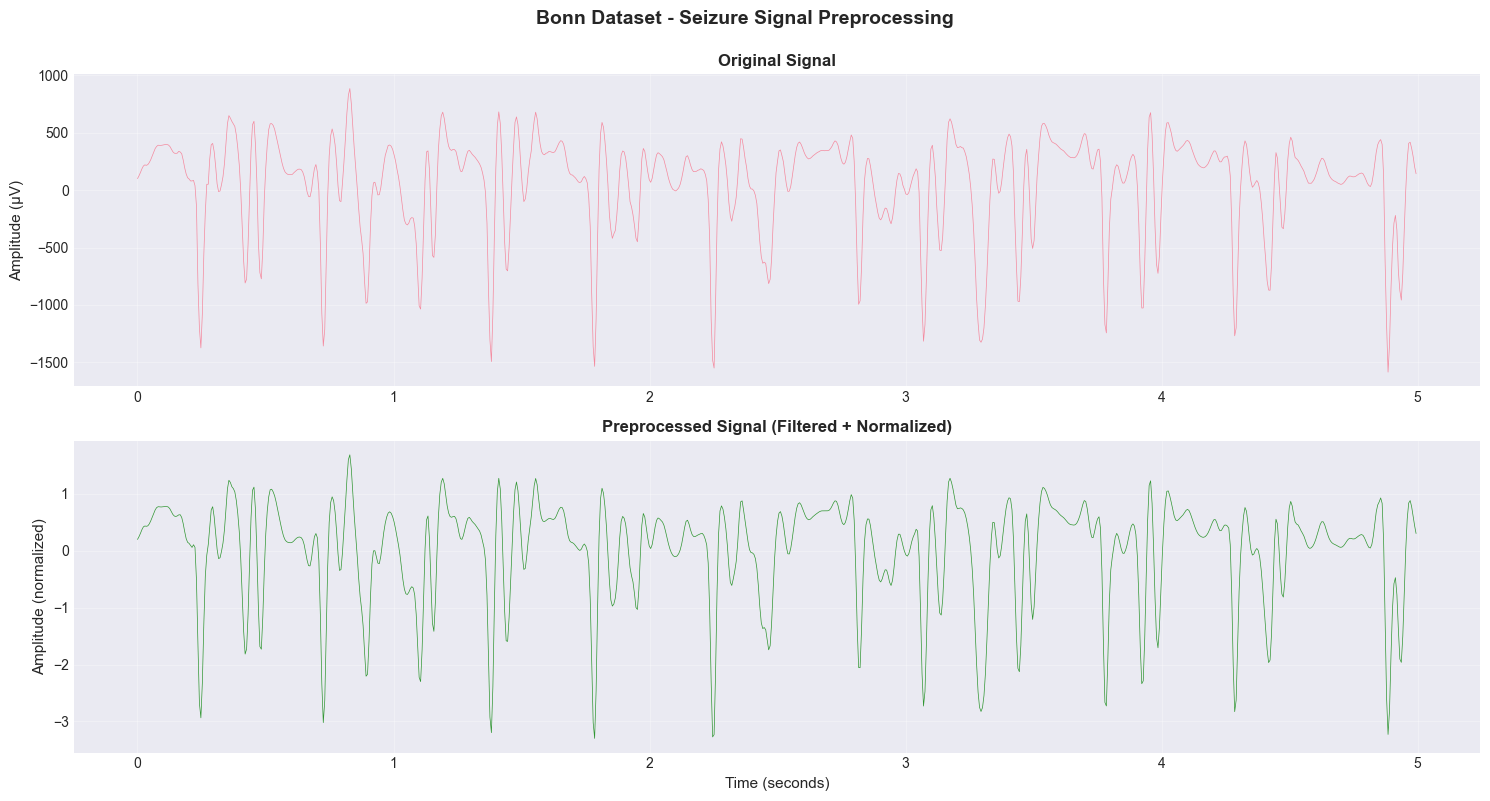

In [14]:
# Visualize preprocessing effects
print("\nCreating comparison visualizations...")

# Seizure signal comparison
fig = plot_preprocessing_comparison(
    sample_seizure, seizure_normalized,
    config['sampling_rate'],
    title="Bonn Dataset - Seizure Signal Preprocessing"
)
plt.savefig(FIGURES_DIR / 'bonn_preprocessing_seizure.png', dpi=300, bbox_inches='tight')
plt.show()

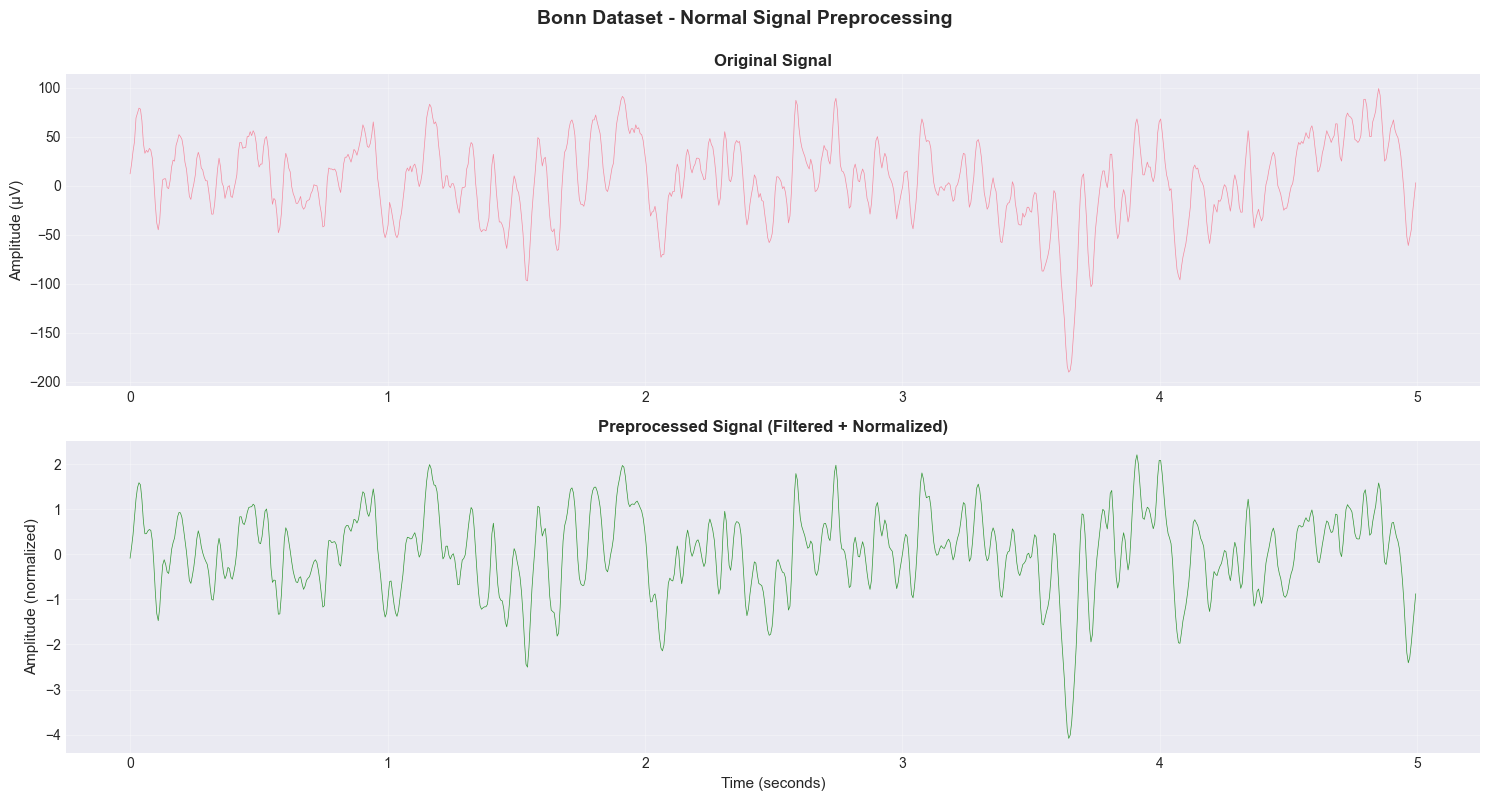

In [15]:
# Normal signal comparison
fig = plot_preprocessing_comparison(
    sample_normal, normal_normalized,
    config['sampling_rate'],
    title="Bonn Dataset - Normal Signal Preprocessing"
)
plt.savefig(FIGURES_DIR / 'bonn_preprocessing_normal.png', dpi=300, bbox_inches='tight')
plt.show()

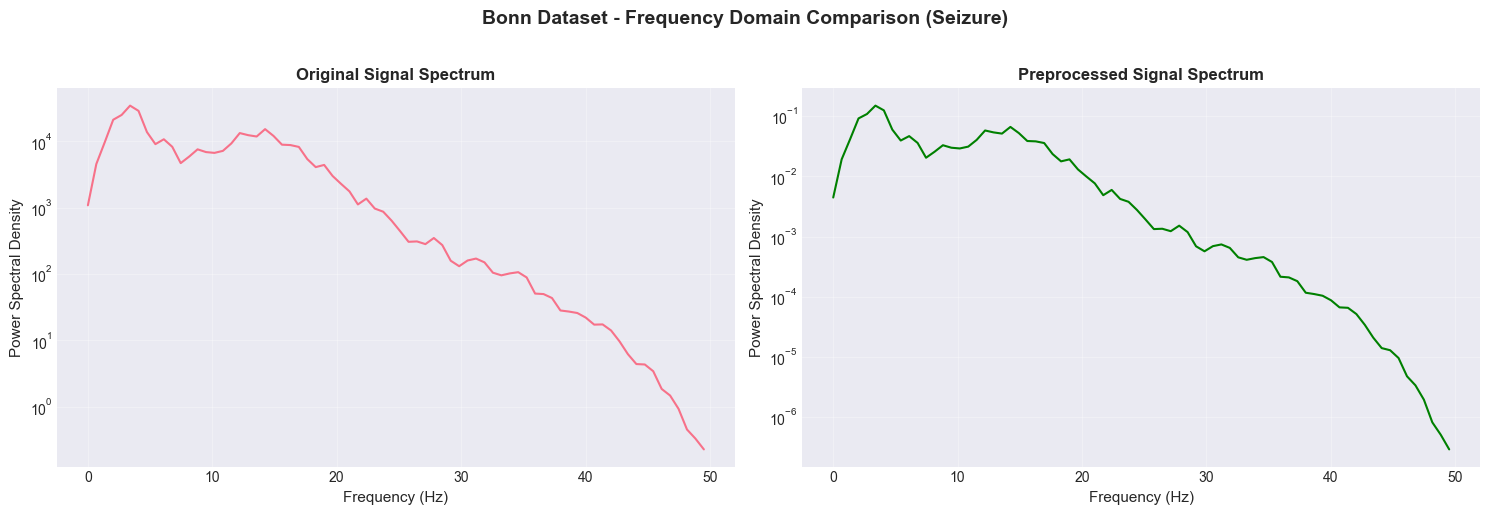

✓ Saved preprocessing comparison figures


In [16]:
# Frequency comparison
fig = plot_frequency_comparison(
    sample_seizure, seizure_normalized,
    config['sampling_rate'],
    title="Bonn Dataset - Frequency Domain Comparison (Seizure)"
)
plt.savefig(FIGURES_DIR / 'bonn_frequency_comparison.png',  dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved preprocessing comparison figures")

In [18]:
# Preprocess entire Bonn dataset
print("\n" + "="*80)
print("Processing All Bonn Segments...")
print("="*80)

bonn_preprocessed = []

for i, segment in enumerate(tqdm(bonn_data, desc="Preprocessing Bonn")):
    # Apply full preprocessing pipeline
    processed, _ = preprocess_pipeline(
        segment,
        sampling_rate=config['sampling_rate'],
        apply_bandpass=True,
        apply_notch=config['apply_notch'],
        apply_normalize=True,
        segment=False
    )
    bonn_preprocessed.append(processed)

bonn_preprocessed = np.array(bonn_preprocessed)

print(f"\n✓ Preprocessed Bonn Dataset:")
print(f"  - Shape: {bonn_preprocessed.shape}")
print(f"  - Mean: {np.mean(bonn_preprocessed):.6f}")
print(f"  - Std: {np.std(bonn_preprocessed):.6f}")

# Save preprocessed data
print("\nSaving preprocessed Bonn data...")
np.save(PROCESSED_DIR / 'bonn' / 'preprocessed_data.npy', bonn_preprocessed)
np.save(PROCESSED_DIR / 'bonn' / 'labels.npy', bonn_labels)


Processing All Bonn Segments...


Preprocessing Bonn:  16%|█▌        | 81/500 [00:00<00:00, 795.29it/s]

✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass f

Preprocessing Bonn:  57%|█████▋    | 287/500 [00:00<00:00, 966.62it/s]

✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass f

Preprocessing Bonn: 100%|██████████| 500/500 [00:00<00:00, 978.16it/s] 

✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass filter (0.5-50 Hz)
✓ Applied z-score normalization
✓ Applied bandpass f

In [ ]:
# ============================================================================
# PREPROCESS SAMPLE OF CHB-MIT DATASET 
# ============================================================================

In [19]:
print("\n" + "="*80)
print("PREPROCESSING CHB-MIT DATASET")
print("="*80)

# Load CHB-MIT sample
chbmit_loader = CHBMITDataLoader(CHB_MIT_PATH)

# Load one patient file
raw = chbmit_loader.load_patient_file('chb01', file_idx=0)

if raw is not None:
    config_chb = PREPROCESSING_CONFIG['chb_mit']
    chb_preprocessor = EEGPreprocessor(config_chb['sampling_rate'])

    # Get data (first 10 seconds for testing)
    duration = 10  # seconds
    data_chb, times = raw[:, :int(duration * raw.info['sfreq'])]
    
    # Select one channel for testing
    channel_idx = 0
    channel_name = raw.ch_names[channel_idx]
    channel_data = data_chb[channel_idx]
    
    print(f"\nProcessing channel: {channel_name}")
    print(f"  - Duration: {duration} seconds")
    print(f"  - Samples: {len(channel_data)}")
    
    # Apply preprocessing
    print("\nApplying Preprocessing Pipeline...")
    
    # Bandpass filter
    filtered = chb_preprocessor.bandpass_filter(
        channel_data,
        lowcut=config_chb['bandpass_low'],
        highcut=config_chb['bandpass_high']
    )

    # Notch filter
    notched = chb_preprocessor.notch_filter(filtered, freq=config_chb['notch_freq']) 
    
    # Normalize
    normalized = chb_preprocessor.normalize(notched, method='zscore')
   


PREPROCESSING CHB-MIT DATASET
Loaded: chb01_01.edf
  - Channels: 23
  - Duration: 3600.00 seconds
  - Sampling Rate: 256.0 Hz

Processing channel: FP1-F7
  - Duration: 10 seconds
  - Samples: 2560

Applying Preprocessing Pipeline...


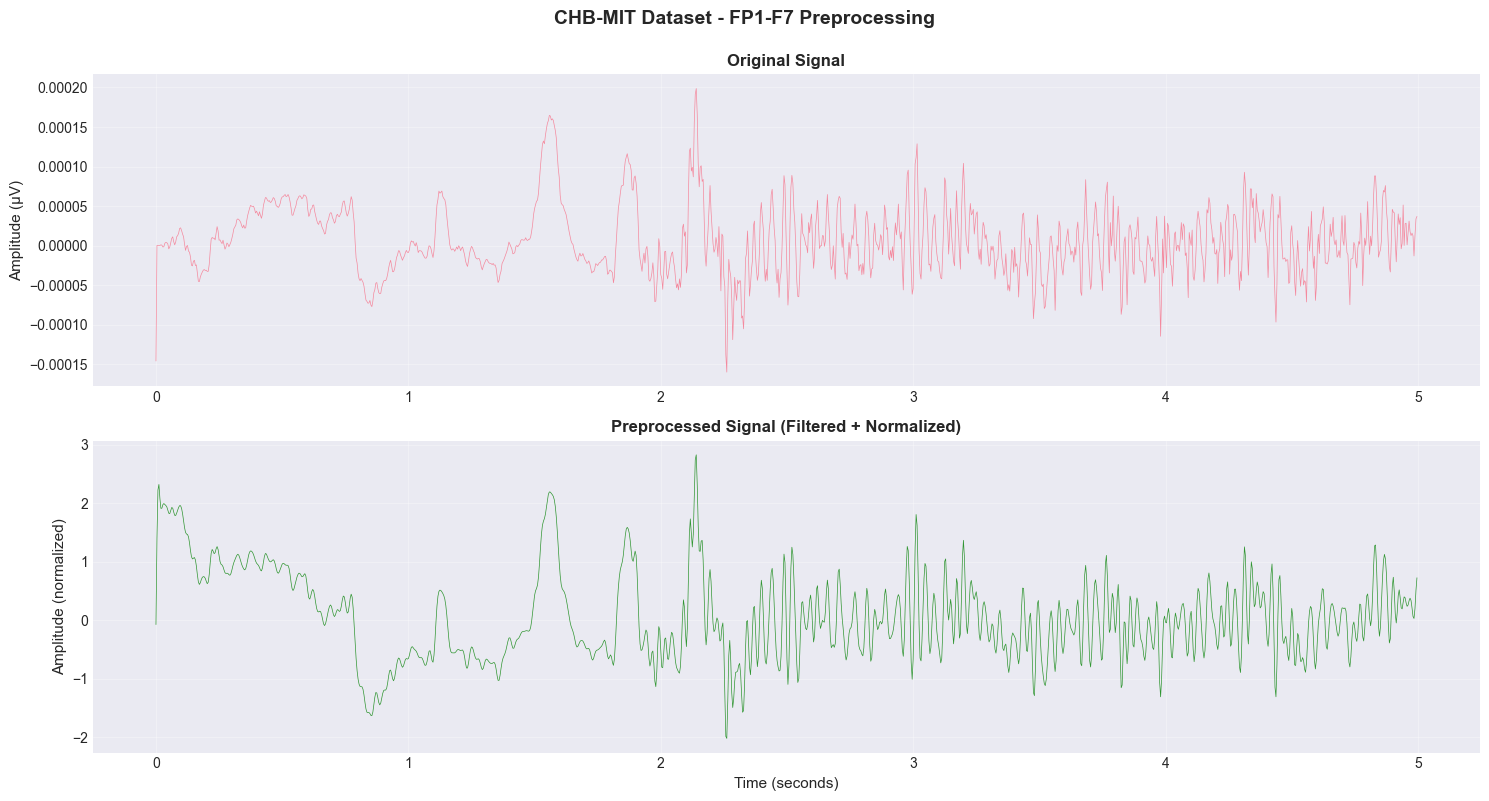

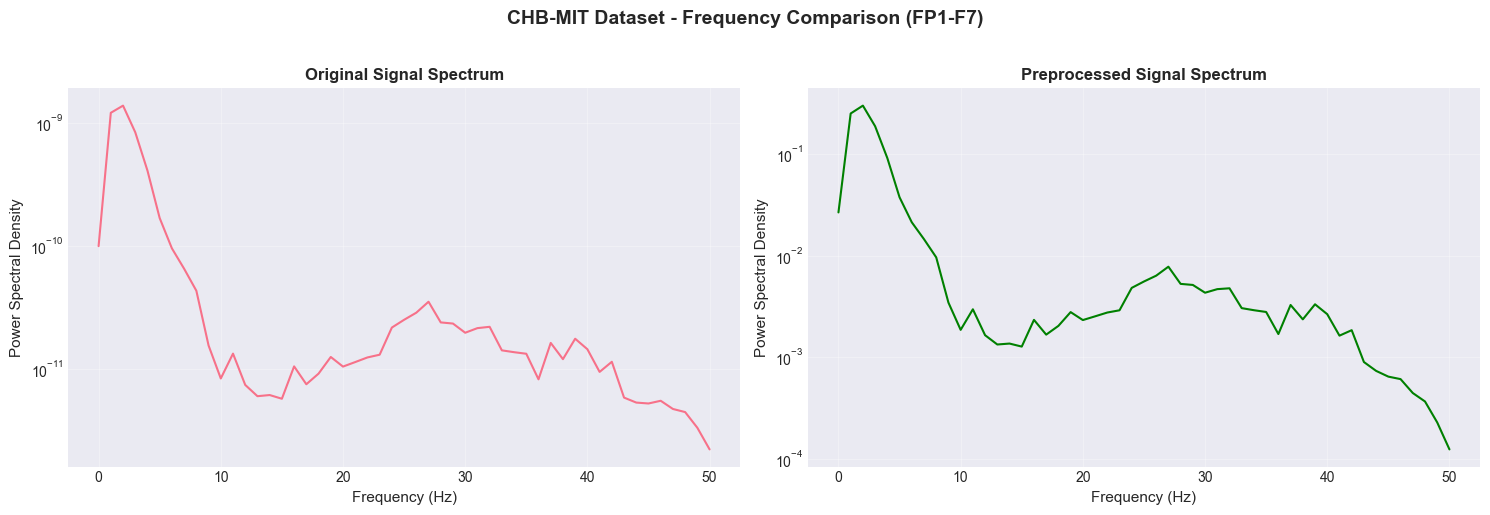

Saved CHB-MIT preprocessing figures


In [20]:
     
# Visualize
fig = plot_preprocessing_comparison(
    channel_data, normalized,
    config_chb['sampling_rate'],
    title=f"CHB-MIT Dataset - {channel_name} Preprocessing"
)
plt.savefig(FIGURES_DIR / 'chbmit_preprocessing_sample.png', dpi=300, bbox_inches='tight')
plt.show()

# Frequency comparison
fig = plot_frequency_comparison(
    channel_data, normalized,
    config_chb['sampling_rate'],
    title=f"CHB-MIT Dataset - Frequency Comparison ({channel_name})"
)
plt.savefig(FIGURES_DIR / 'chbmit_frequency_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved CHB-MIT preprocessing figures")

In [ ]:
# ============================================================================
# SEGMENTATION
# ============================================================================

In [22]:
print("\nSegmenting Bonn Data into Windows...")

# Segment preprocessed Bonn data
window_size = config['window_size']
overlap = config['overlap']

bonn_segments = []
bonn_segment_labels = []

for i, (segment, label) in enumerate(zip(bonn_preprocessed, bonn_labels)):
    # Each segment is already 23.6 seconds

    segments_per_signal, _ = bonn_preprocessor.segment_signal(
        segment, 
        window_size=window_size,
        overlap=overlap
    )
    
    # Add to list
    for seg in segments_per_signal:
        bonn_segments.append(seg)
        bonn_segment_labels.append(label)

bonn_segments = np.array(bonn_segments)
bonn_segment_labels = np.array(bonn_segment_labels)

print(f"\nSegmentation Complete:")
print(f"  - Original segments: {len(bonn_preprocessed)}")
print(f"  - Window size: {window_size}s")
print(f"  - Overlap: {overlap*100}%")
print(f"  - Total windows: {len(bonn_segments)}")
print(f"  - Window shape: {bonn_segments[0].shape}")
print(f"  - Class distribution: {bonn_segment_labels.sum()} seizure, {len(bonn_segment_labels) - bonn_segment_labels.sum()} non-seizure")


Segmenting Bonn Data into Windows...

Segmentation Complete:
  - Original segments: 500
  - Window size: 4.0s
  - Overlap: 50.0%
  - Total windows: 5000
  - Window shape: (694,)
  - Class distribution: 1000.0 seizure, 4000.0 non-seizure


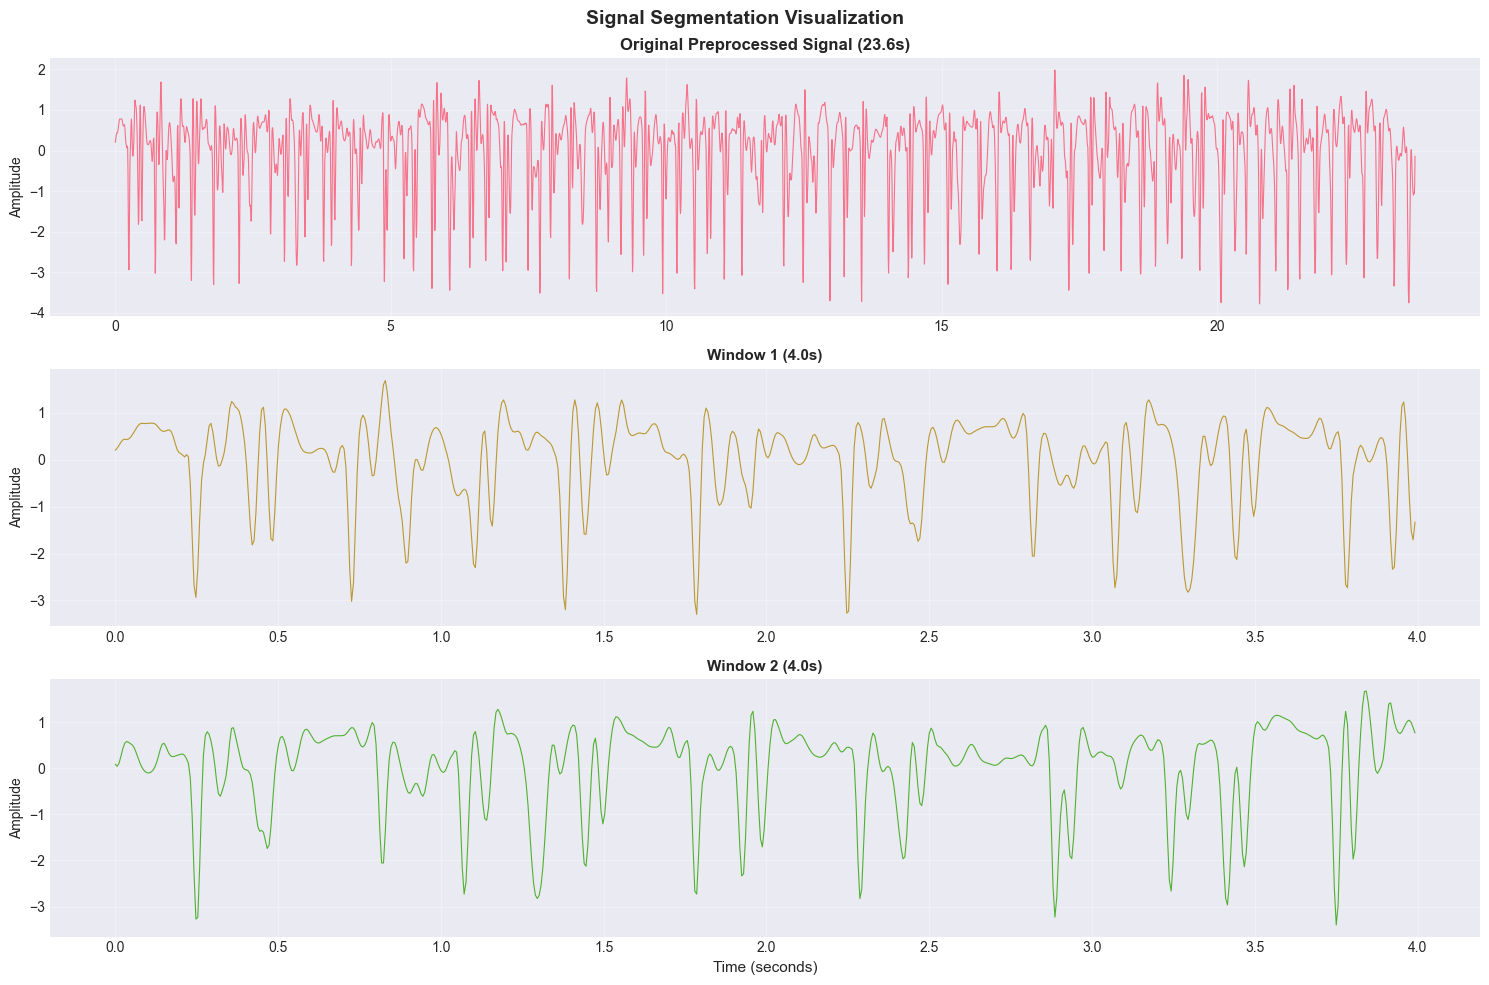

Saved segmentation visualization


In [24]:
# Visualize segmentation
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Show original signal
sample_idx = seizure_idx
original_signal = bonn_preprocessed[sample_idx]
time_orig = np.arange(len(original_signal)) / config['sampling_rate']

axes[0].plot(time_orig, original_signal, linewidth=0.8)
axes[0].set_ylabel('Amplitude', fontsize=10)
axes[0].set_title('Original Preprocessed Signal (23.6s)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Show first few windows
window_samples = int(window_size * config['sampling_rate'])
time_window = np.arange(window_samples) / config['sampling_rate']

# Find segments from this signal (For visualization, taking first 2 segments)
for i in range(2):
    start_sample = int(i * window_samples * (1 - overlap))
    window_data = original_signal[start_sample:start_sample + window_samples]
    
    axes[i+1].plot(time_window, window_data, linewidth=0.8, color=f'C{i+1}')
    axes[i+1].set_ylabel('Amplitude', fontsize=10)
    axes[i+1].set_title(f'Window {i+1} ({window_size}s)', fontsize=11, fontweight='bold')
    axes[i+1].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (seconds)', fontsize=11)

plt.suptitle('Signal Segmentation Visualization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'segmentation_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved segmentation visualization")

In [25]:
# Save segmented data
print("\nSaving segmented data...")
np.save(PROCESSED_DIR / 'bonn' / 'segmented_data.npy', bonn_segments)
np.save(PROCESSED_DIR / 'bonn' / 'segmented_labels.npy', bonn_segment_labels)


Saving segmented data...


In [ ]:
# ============================================================================
# DATA AUGMENTATION 
# ============================================================================

In [26]:
def augment_signal(signal, method='noise', noise_level=0.05):
    """
    Augment EEG signal
    
    Methods:
    - 'noise': Add Gaussian noise
    - 'scale': Random amplitude scaling
    - 'shift': Time shift
    """
    if method == 'noise':
        noise = np.random.normal(0, noise_level, len(signal))
        return signal + noise
    
    elif method == 'scale':
        scale = np.random.uniform(0.9, 1.1)
        return signal * scale
    
    elif method == 'shift':
        shift = np.random.randint(-10, 10)
        return np.roll(signal, shift)
    
    return signal

print("\nApplying Data Augmentation to Minority Class (Seizure)...")


Applying Data Augmentation to Minority Class (Seizure)...


In [27]:
# Identify minority class (seizure)
seizure_mask = bonn_segment_labels == 1
n_seizure = np.sum(seizure_mask)
n_normal = np.sum(~seizure_mask)

print(f"  - Normal samples: {n_normal}")
print(f"  - Seizure samples: {n_seizure}")
print(f"  - Imbalance ratio: {n_normal/n_seizure:.2f}:1")

  - Normal samples: 4000
  - Seizure samples: 1000
  - Imbalance ratio: 4.00:1


In [28]:
# Augment seizure samples to balance
n_augment = n_normal - n_seizure
augmented_segments = []
augmented_labels = []

seizure_segments = bonn_segments[seizure_mask]

for _ in range(n_augment):
    # Randomly select a seizure sample
    idx = np.random.randint(0, len(seizure_segments))
    sample = seizure_segments[idx]
    
    # Randomly choose augmentation method
    method = np.random.choice(['noise', 'scale'])
    augmented = augment_signal(sample, method=method)
    
    augmented_segments.append(augmented)
    augmented_labels.append(1)  # Seizure

augmented_segments = np.array(augmented_segments)
augmented_labels = np.array(augmented_labels)

print(f"Generated {len(augmented_segments)} augmented samples")

Generated 3000 augmented samples


In [33]:
# Combine original and augmented data
bonn_augmented = np.vstack([bonn_segments, augmented_segments])
labels_augmented = np.concatenate([bonn_segment_labels, augmented_labels])

print(f"\nAugmented Dataset:")
print(f"  - Total samples: {len(bonn_augmented)}")
print(f"  - Class distribution: {labels_augmented.sum()} seizure, {len(labels_augmented) - labels_augmented.sum()} non-seizure")




Augmented Dataset:
  - Total samples: 8000
  - Class distribution: 4000.0 seizure, 4000.0 non-seizure


In [34]:
# Save augmented data
np.save(PROCESSED_DIR / 'bonn' / 'augmented_data.npy', bonn_augmented)
np.save(PROCESSED_DIR / 'bonn' / 'augmented_labels.npy', labels_augmented)


In [35]:
# ============================================================================
# TRAIN/VALIDATION/TEST SPLIT
# ============================================================================

In [36]:
print("\n" + "="*80)
print("CREATING DATA SPLITS")
print("="*80)

from sklearn.model_selection import train_test_split

# Using augmented data
X = bonn_augmented
y = labels_augmented

# Split: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"\nData Split Complete:")
print(f"  - Training set: {len(X_train)} samples")
print(f"    • Normal: {np.sum(y_train == 0)}, Seizure: {np.sum(y_train == 1)}")
print(f"  - Validation set: {len(X_val)} samples")
print(f"    • Normal: {np.sum(y_val == 0)}, Seizure: {np.sum(y_val == 1)}")
print(f"  - Test set: {len(X_test)} samples")
print(f"    • Normal: {np.sum(y_test == 0)}, Seizure: {np.sum(y_test == 1)}")



CREATING DATA SPLITS

Data Split Complete:
  - Training set: 5600 samples
    • Normal: 2800, Seizure: 2800
  - Validation set: 1200 samples
    • Normal: 600, Seizure: 600
  - Test set: 1200 samples
    • Normal: 600, Seizure: 600


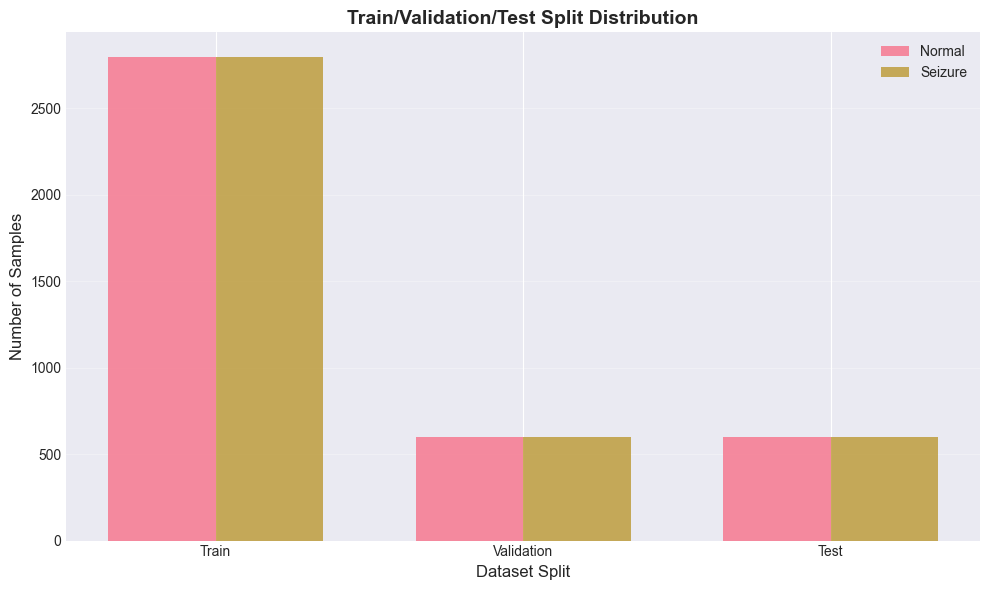

In [37]:
# Visualize split
fig, ax = plt.subplots(figsize=(10, 6))

splits = ['Train', 'Validation', 'Test']
normal_counts = [np.sum(y_train == 0), np.sum(y_val == 0), np.sum(y_test == 0)]
seizure_counts = [np.sum(y_train == 1), np.sum(y_val == 1), np.sum(y_test == 1)]

x = np.arange(len(splits))
width = 0.35

ax.bar(x - width/2, normal_counts, width, label='Normal', alpha=0.8)
ax.bar(x + width/2, seizure_counts, width, label='Seizure', alpha=0.8)

ax.set_xlabel('Dataset Split', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('Train/Validation/Test Split Distribution', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'data_split_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
# Save splits
print("\nSaving train/val/test splits...")
split_dir = PROCESSED_DIR / 'bonn' / 'splits'
split_dir.mkdir(exist_ok=True)

np.save(split_dir / 'X_train.npy', X_train)
np.save(split_dir / 'y_train.npy', y_train)
np.save(split_dir / 'X_val.npy', X_val)
np.save(split_dir / 'y_val.npy', y_val)
np.save(split_dir / 'X_test.npy', X_test)
np.save(split_dir / 'y_test.npy', y_test)

print("Saved all splits to data/processed/bonn/splits/")


Saving train/val/test splits...
Saved all splits to data/processed/bonn/splits/
